# Cell level classifiers using pre-trained ResNet-18 features

In [1]:
import importlib 
import util, models, training, eval

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)
importlib.reload(eval)

<module 'eval' from '/home/unix/hschluet/projects/pt-pbmc/eval.py'>

In [2]:
from data import PlateDataset
from util import torch_random_choice
from models import MultiFeatClassifier, FeatClassifier
from training import train_model

import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns


device = 'cuda:5'

In [3]:
data = PlateDataset([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

  0%|                                                                                                                                                                                          | 0/14 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


In [4]:
data.info

,plate,well,series,cell,patient,time,qc,group
0,3,A02,0,5,P115,2,True,H&N cancer
1,3,A02,0,6,P115,2,True,H&N cancer
2,3,A02,0,9,P115,2,True,H&N cancer
3,3,A02,0,12,P115,2,True,H&N cancer
4,3,A02,0,18,P115,2,True,H&N cancer
...,...,...,...,...,...,...,...,...
996648,16,H12,9,565,H15,0,True,healthy
996649,16,H12,9,569,H15,0,True,healthy
996650,16,H12,9,570,H15,0,True,healthy
996651,16,H12,9,572,H15,0,True,healthy


In [5]:
data.imgs.shape

torch.Size([996653, 1, 32, 32])

In [6]:
from torchvision.models import resnet18 as make_resnet18
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import DataLoader


def extract_resnet_patch_features(imgs, transform=None):
  model = make_resnet18(weights="DEFAULT").to(device)
  return_nodes = {
      'flatten': 'z',
  }
  feature_extractor = create_feature_extractor(model.eval().to(device), return_nodes=return_nodes)
  z = torch.zeros((len(imgs), 512))
  i = 0
  loader = DataLoader(imgs, batch_size=128, shuffle=False)
  for img_batch in tqdm(loader):
    img_batch = img_batch.to(device).repeat(1, 3, 1, 1)
    if transform is not None:
      img_batch = transform(img_batch)
    with torch.no_grad():
      z[i:i+len(img_batch)] = feature_extractor(img_batch)['z'].cpu()
    i += len(img_batch)
  return z


res_zs = extract_resnet_patch_features(data.imgs)
res_zs.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7787/7787 [00:25<00:00, 311.41it/s]


torch.Size([996653, 512])

## Classification between largest cancer types and healthy

Include healthy in objective as it is shared across plates and cancer types classification could cheat using plate effect.

In [7]:
data.info.groupby(['plate', 'group'])['cell'].count()

plate  group                   
3      H&N cancer                   15259
       healthy                       1717
4      H&N cancer                   88198
       healthy                       8861
5      H&N cancer                   15530
       healthy                       1661
6      H&N cancer                   64118
       healthy                       4591
7      CNS-Meningioma               88192
       healthy                      13659
8      CNS-Meningioma               32397
       Lymphoma                     46938
       healthy                       9107
9      CNS-Meningioma               18910
       healthy                       4418
10     Chordoma/Chondrosarcoma      70034
       healthy                       5830
11     Chordoma/Chondrosarcoma      39004
       healthy                       2445
12     CNS-Ependymoma               80228
       Chordoma/Chondrosarcoma      43113
       healthy                      10337
13     CNS-other                   119725
  

In [8]:
data.info.groupby(['plate', 'group'])['patient'].unique()

plate  group                   
3      H&N cancer                   [P115, P72, P50, P67, P100, P77, P56, P125, P41]
       healthy                                                  [H06, H30, H23, H07]
4      H&N cancer                  [P129, P137, P107, P114, P149, P79, P120, P145...
       healthy                                                  [H40, H10, H30, H23]
5      H&N cancer                  [P148, P78, P63, P24, P18, P135, P12, P142, P161]
       healthy                                                  [H40, H31, H10, H39]
6      H&N cancer                  [P94, P166, P147, P14, P154, P55, P44, P98, P1...
       healthy                                                  [H31, H22, H37, H39]
7      CNS-Meningioma              [P102, P119, P70, P105, P59, P128, P48, P134, ...
       healthy                                                  [H22, H37, H26, H47]
8      CNS-Meningioma                                          [P162, P37, P42, P27]
       Lymphoma                  

In [9]:
use_plates = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
use_groups = ['healthy', 'H&N cancer', 'CNS-Meningioma', 'Chordoma/Chondrosarcoma'] 
cdf = data.info[data.info['group'].isin(use_groups) & data.info['plate'].isin(use_plates)].groupby(
    ['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H06', 'H07', 'H09', 'H10', 'H16', 'H19', 'H20', 'H22', 'H23',
       'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36', 'H37', 'H39',
       'H40', 'H43', 'H47', 'H49', 'P102', 'P105', 'P106', 'P107', 'P110',
       'P112', 'P114', 'P115', 'P118', 'P119', 'P120', 'P125', 'P126',
       'P128', 'P129', 'P130', 'P131', 'P134', 'P135', 'P137', 'P138',
       'P14', 'P142', 'P143', 'P144', 'P145', 'P147', 'P148', 'P149',
       'P152', 'P154', 'P155', 'P160', 'P161', 'P162', 'P163', 'P165',
       'P166', 'P18', 'P21', 'P23', 'P24', 'P25', 'P27', 'P33', 'P37',
       'P38', 'P42', 'P43', 'P44', 'P48', 'P55', 'P59', 'P62', 'P63',
       'P67', 'P69', 'P70', 'P72', 'P76', 'P78', 'P79', 'P83', 'P86',
       'P90', 'P92', 'P94', 'P98', 'P99'], dtype=object)

In [10]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma               7
CNS-Medulloblastoma          7
CNS-Meningioma              19
CNS-other                   12
Chordoma/Chondrosarcoma     21
H&N cancer                  37
Lymphoma                     7
Sarcoma-Ewing                8
Sarcoma-Neuroblastoma        2
Sarcoma-Rhabdomyosarcoma     4
Sarcoma-other                3
healthy                     30
Name: patient, dtype: int64

In [11]:
use_plates = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
use_groups = ['healthy', 'H&N cancer', 'CNS-Meningioma', 'Chordoma/Chondrosarcoma'] 
short_groups = {'healthy' : 'H', 'H&N cancer' : 'H&N', 'CNS-Meningioma' : 'M', 
                'Chordoma/Chondrosarcoma' : 'C/C'}  
group_map = {'healthy' : 0, 'H&N cancer' : 1, 'CNS-Meningioma' : 2, 'Chordoma/Chondrosarcoma' : 3} 

def group_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = res_zs[use_idx].to(device)
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['group'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)]).loc[use_groups]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
  pat_min = pat_groups.map(len).min()

  while True:
    labels = []
    xs = []
    for label in use_groups:
      pat_sub = np.random.choice(pat_groups[label], size=pat_min, replace=False)
      for pat in pat_sub:
        xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
        labels.extend([group_map[label]] * bag_size)

    labels = torch.tensor(labels).to(device) 
    xs = torch.cat(xs).float()
    # shuffle indices
    rand_idx = torch.randperm(len(xs))
    for left in range(0, bag_size * len(use_groups) * pat_min, bag_size):
      yield xs[rand_idx[left:left+bag_size]], labels[rand_idx[left:left+bag_size]]


def test_group_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = res_zs[use_idx].to(device)
  use_imgs = transform(data.imgs[use_idx].to(device))
  
  pat_groups = data.info.groupby(['patient'])['group'].max()
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    idx = torch_random_choice(pat_idx, size=bag_size)
    xs = use_data[idx]
    label = pat_groups[pat]
    yield xs.float(), use_imgs[idx].float(), torch.tensor(group_map[label]).to(device), pat, label

In [12]:
def eval_model(name, loader, classes=5):
    model = MultiFeatClassifier(classes=classes)
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (z, bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, _ = model(z.to(device))
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

### Big model

iter: 399999; train loss: 0.49535519; train error: 0.20000005: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:21<00:00, 498.93it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_by_cell_pretrained_resnet_model.pt


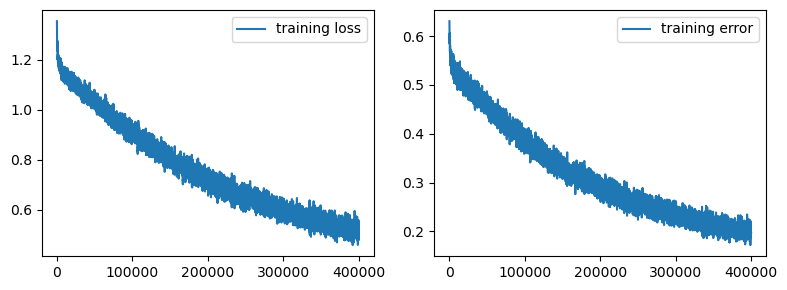

In [13]:
name = '3_12_t01_healthy_groups_by_cell_pretrained_resnet'
train_loader = group_bagloader()
model = MultiFeatClassifier(classes=len(use_groups))
df = train_model(model, bag_loader=train_loader, num_iter=400_000, lr=0.0001, device=device, fname=name, plot=False, 
                 save_model=True, seed=12341)

w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [14]:
dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('3_12_t01_healthy_groups_by_cell_pretrained_resnet', test_group_bagloader(use_plates=[plate]), classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)
res_df

 10%|█████████████████▊                                                                                                                                                                | 1/10 [00:00<00:02,  4.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.29it/s]


,lab,pred,i,pat,group,plate
0,0,0,0,H06,healthy,3
1,0,0,0,H06,healthy,3
2,0,1,0,H06,healthy,3
3,0,0,0,H06,healthy,3
4,0,0,0,H06,healthy,3
...,...,...,...,...,...,...
10895,3,3,6,P21,Chordoma/Chondrosarcoma,12
10896,3,1,6,P21,Chordoma/Chondrosarcoma,12
10897,3,3,6,P21,Chordoma/Chondrosarcoma,12
10898,3,3,6,P21,Chordoma/Chondrosarcoma,12


In [15]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df

,plate,pat,group,pred,counts
0,3,H06,H,H,91
1,3,H06,H,H&N,6
2,3,H06,H,M,3
3,3,H07,H,H,100
4,3,H23,H,H,72
...,...,...,...,...,...
373,12,P155,C/C,H&N,10
374,12,P21,C/C,C/C,73
375,12,P21,C/C,M,16
376,12,P21,C/C,H&N,7


/tmp/ipykernel_3721294/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_3721294/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_3721294/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_3721294

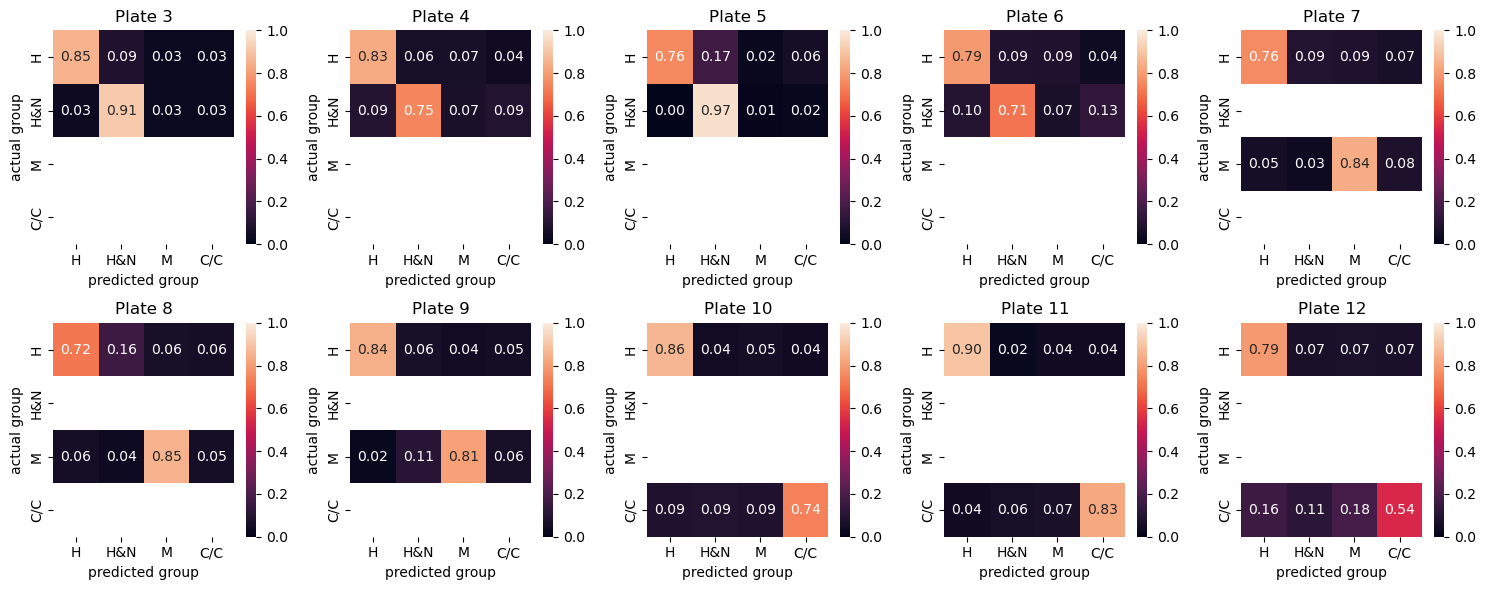

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

/tmp/ipykernel_3721294/1759129104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


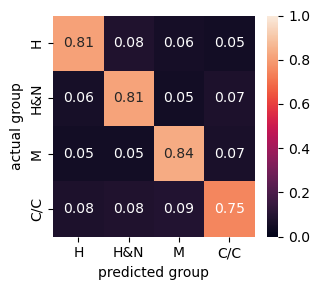

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

### Leave out one plate

  0%|                                                                                                                                                                                      | 0/400000 [00:00<?, ?it/s]

iter: 399999; train loss: 0.50731838; train error: 0.25999999: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:30<00:00, 493.31it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_3_by_cell_pretrained_resnet_model.pt


iter: 399999; train loss: 0.50157434; train error: 0.22000003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:20<00:00, 499.48it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_4_by_cell_pretrained_resnet_model.pt


iter: 399999; train loss: 0.76697493; train error: 0.25999999: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [12:37<00:00, 527.85it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_5_by_cell_pretrained_resnet_model.pt


iter: 399999; train loss: 0.33507141; train error: 0.18000001: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [11:39<00:00, 571.96it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_6_by_cell_pretrained_resnet_model.pt


iter: 399999; train loss: 0.38512218; train error: 0.16000003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [11:26<00:00, 583.04it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_7_by_cell_pretrained_resnet_model.pt


iter: 399999; train loss: 0.35180676; train error: 0.12000000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [12:05<00:00, 551.07it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_8_by_cell_pretrained_resnet_model.pt


iter: 399999; train loss: 0.55677003; train error: 0.20000005: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [12:23<00:00, 537.71it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_9_by_cell_pretrained_resnet_model.pt


iter: 399999; train loss: 0.31616849; train error: 0.14000005: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [12:31<00:00, 532.27it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_10_by_cell_pretrained_resnet_model.pt


iter: 399999; train loss: 0.57266438; train error: 0.22000003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [11:57<00:00, 557.59it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_11_by_cell_pretrained_resnet_model.pt


iter: 399999; train loss: 0.37288001; train error: 0.10000002: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [12:21<00:00, 539.30it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_12_by_cell_pretrained_resnet_model.pt


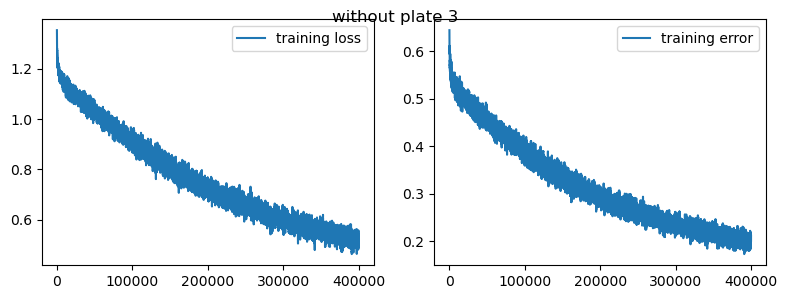

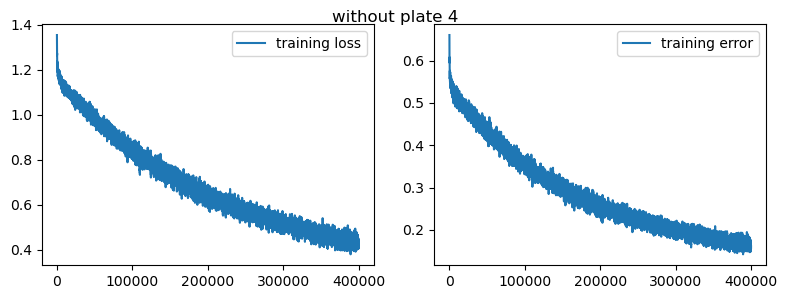

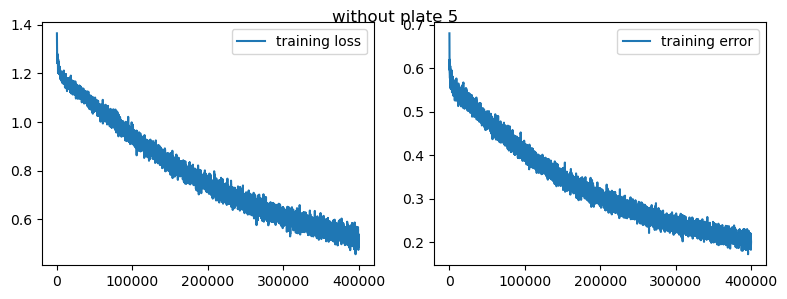

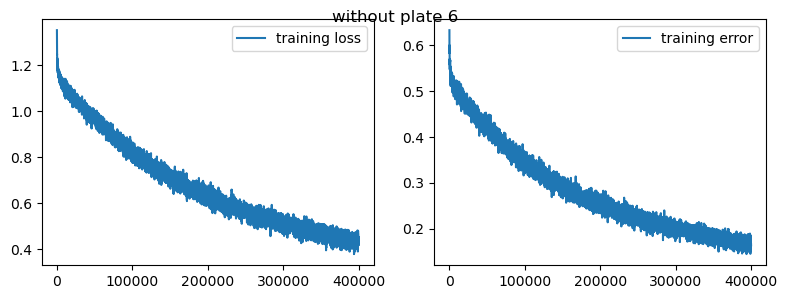

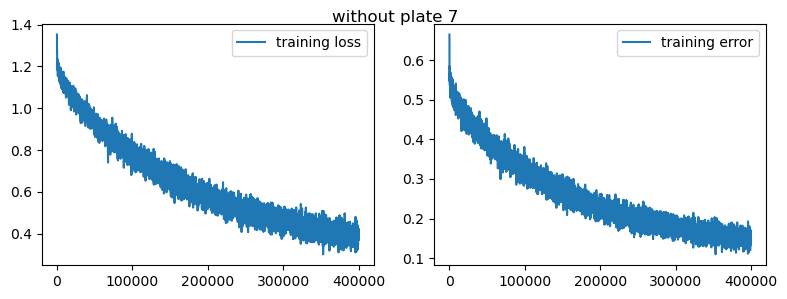

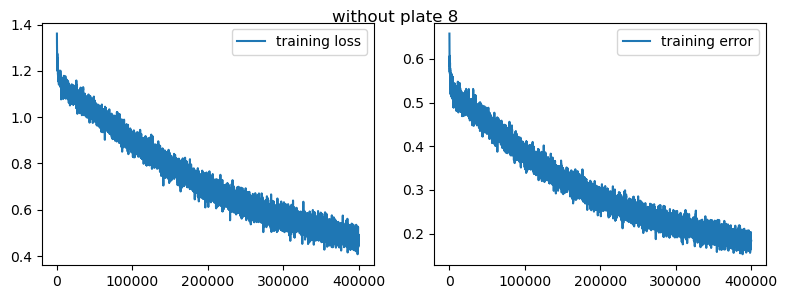

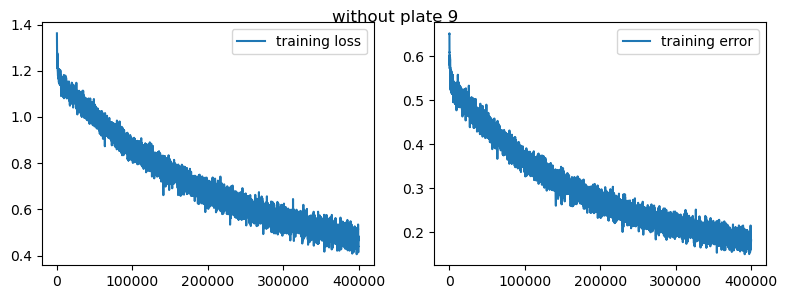

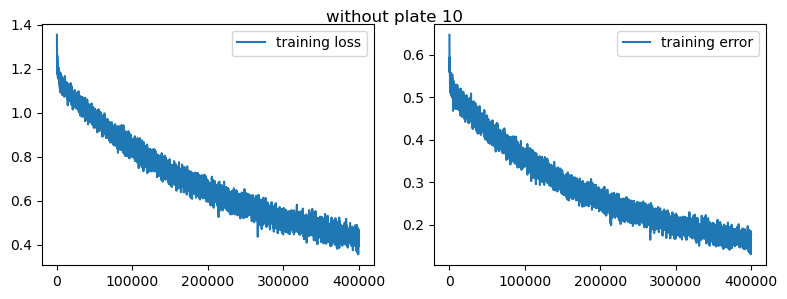

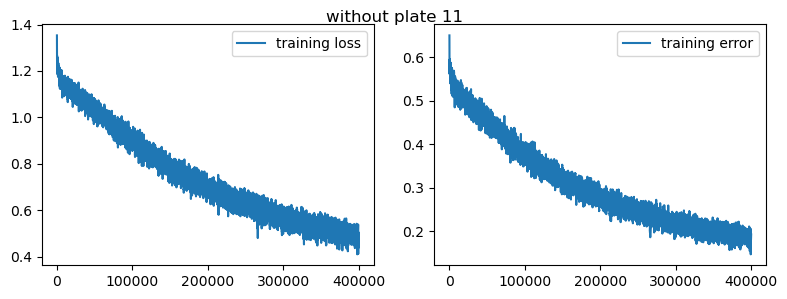

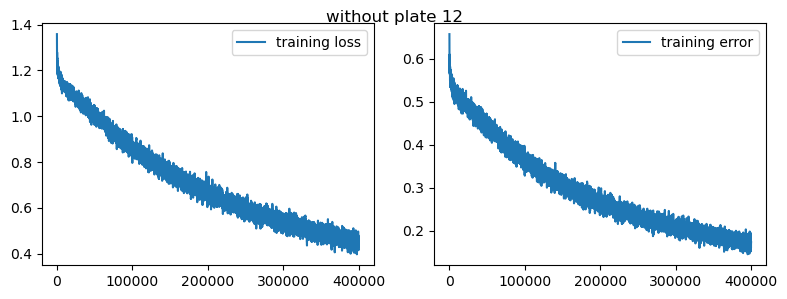

In [18]:
for plate in use_plates:
    name = f'3_12_t01_healthy_cancer_without_plate_{plate}_by_cell_pretrained_resnet'
    train_loader = group_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = MultiFeatClassifier(classes=len(use_groups))
    df = train_model(model, bag_loader=train_loader, num_iter=400_000, lr=0.0001, device=device, fname=name, plot=False, 
                     save_model=True, seed=12341)

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

In [19]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'3_12_t01_healthy_cancer_without_plate_{plate}_by_cell_pretrained_resnet', 
                        test_group_bagloader(use_plates=[plate]), classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

  0%|                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.33it/s]


,lab,pred,i,pat,group,plate
0,0,0,0,H06,healthy,3
1,0,2,0,H06,healthy,3
2,0,1,0,H06,healthy,3
3,0,0,0,H06,healthy,3
4,0,0,0,H06,healthy,3
...,...,...,...,...,...,...
10895,3,1,6,P21,Chordoma/Chondrosarcoma,12
10896,3,1,6,P21,Chordoma/Chondrosarcoma,12
10897,3,3,6,P21,Chordoma/Chondrosarcoma,12
10898,3,1,6,P21,Chordoma/Chondrosarcoma,12


In [20]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df

,plate,pat,group,pred,counts
0,3,H06,H,H,56
1,3,H06,H,H&N,22
2,3,H06,H,M,13
3,3,H06,H,C/C,9
4,3,H07,H,H,56
...,...,...,...,...,...
430,12,P155,C/C,H&N,15
431,12,P21,C/C,C/C,37
432,12,P21,C/C,H&N,27
433,12,P21,C/C,M,22


/tmp/ipykernel_3721294/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_3721294/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_3721294/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_3721294

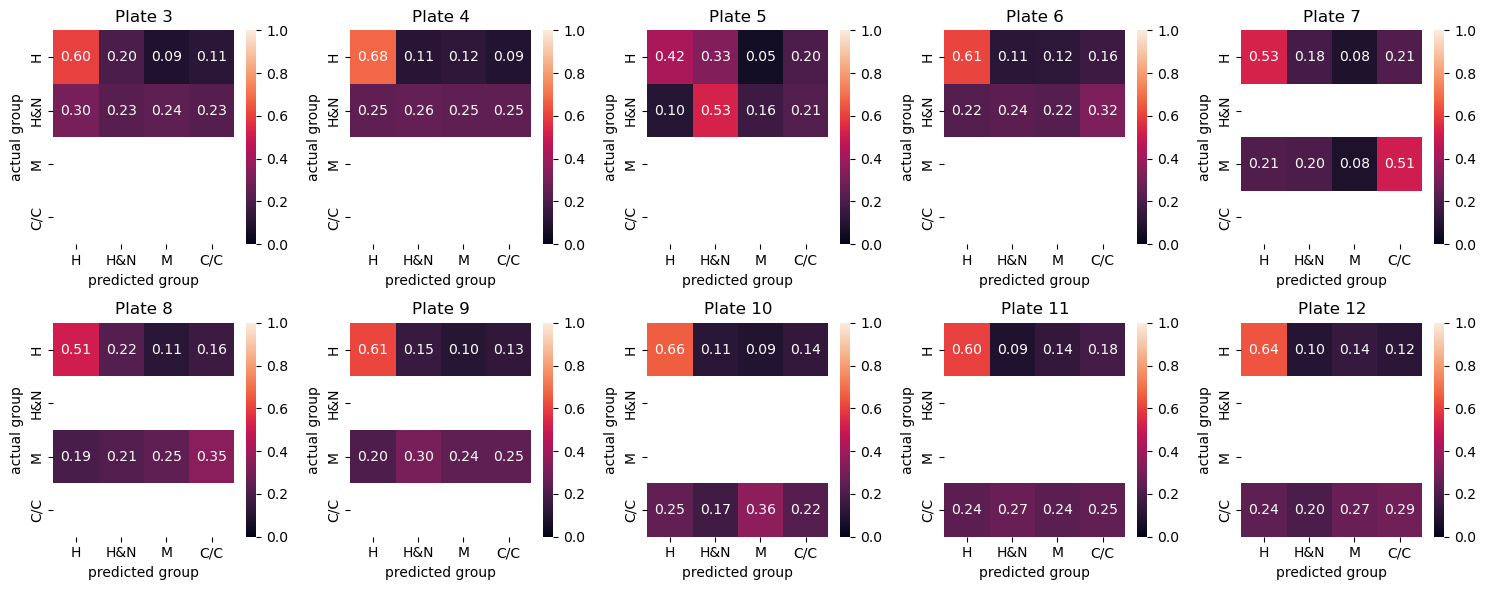

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

/tmp/ipykernel_3721294/1759129104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


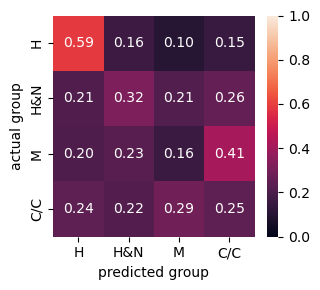

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

## Classification cancer T1 and healthy

In [25]:
use_plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
cdf = data.info[data.info['plate'].isin(use_plates)].groupby(
    ['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H09', 'H10',
       'H13', 'H15', 'H16', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
       'H24', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36',
       'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48', 'H49', 'P102',
       'P103', 'P104', 'P105', 'P106', 'P107', 'P109', 'P11', 'P110',
       'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P117', 'P118',
       'P119', 'P120', 'P121', 'P123', 'P124', 'P125', 'P126', 'P127',
       'P128', 'P129', 'P13', 'P130', 'P131', 'P132', 'P134', 'P135',
       'P136', 'P137', 'P138', 'P139', 'P14', 'P140', 'P142', 'P143',
       'P144', 'P145', 'P146', 'P147', 'P148', 'P149', 'P15', 'P150',
       'P151', 'P152', 'P154', 'P155', 'P156', 'P158', 'P159', 'P16',
       'P160', 'P161', 'P162', 'P163', 'P164', 'P165', 'P166', 'P167',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P27', 'P28', 'P29', 'P30', 'P32', 'P33', 'P34', 'P35', 'P37',
       'P38', 'P

In [26]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma               7
CNS-Glioma                  17
CNS-Medulloblastoma          7
CNS-Meningioma              19
CNS-other                   12
Chordoma/Chondrosarcoma     21
H&N cancer                  37
Lymphoma                     7
Sarcoma-Ewing                8
Sarcoma-Neuroblastoma        2
Sarcoma-Rhabdomyosarcoma     4
Sarcoma-other                3
healthy                     35
Name: patient, dtype: int64

In [27]:
use_plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


def healthy_vs_cancer_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = res_zs[use_idx].to(device)
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['time'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_healthy = pat_groups[0]
  pat_cancer = pat_groups[1]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  pat_min = min(len(pat_healthy), len(pat_cancer))
  while True:
    xs = []
    labels = []
    for lab, pats in zip([0, 1], [pat_cancer, pat_healthy]):
      sub = np.random.choice(pats, size=pat_min, replace=False)
      for pat in sub:
        xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
        labels.append(lab * torch.ones(bag_size))
    
    labels = torch.cat(labels).float().to(device) 
    xs = torch.cat(xs).float()
    # shuffle indices
    rand_idx = torch.randperm(len(xs))
    for left in range(0, bag_size * 2 * pat_min, bag_size):
      yield xs[rand_idx[left:left+bag_size]], labels[rand_idx[left:left+bag_size]]


def test_healthy_vs_cancer_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = res_zs[use_idx].to(device)
  use_imgs = transform(data.imgs[use_idx].to(device))
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    idx = torch_random_choice(pat_idx, size=bag_size)
    xs = use_data[idx]
    label = 1 if pat[0] == 'H' else 0
    yield xs.float(), use_imgs[idx].float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'

In [28]:
def eval_model(name, loader):
    model = FeatClassifier()
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (z, bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, _ = model(z.to(device))
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

In [29]:
xs, labs = next(healthy_vs_cancer_bagloader())
labs

tensor([0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.],
       device='cuda:6')

In [30]:
xs

tensor([[1.2297, 0.1691, 0.0000,  ..., 0.0000, 0.7112, 0.0000],
        [1.2258, 0.0000, 0.4133,  ..., 0.0363, 0.7802, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3418, 0.0000, 0.0000],
        ...,
        [1.1838, 0.0000, 0.2085,  ..., 0.1457, 0.8616, 0.0000],
        [1.2835, 0.0000, 0.5652,  ..., 0.0458, 0.7832, 0.0000],
        [1.3574, 0.0000, 0.1638,  ..., 0.1090, 0.7269, 0.0000]],
       device='cuda:6')

### Big model

iter: 99999; train loss: 0.49370098; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:26<00:00, 484.50it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_by_cell_pretrained_resnet_model.pt


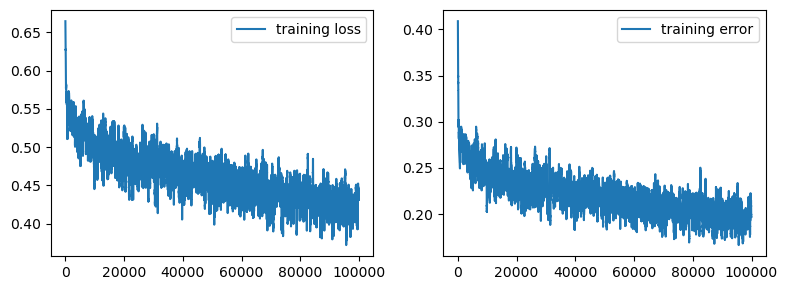

In [31]:
name = '1_16_t01_healthy_cancer_by_cell_pretrained_resnet'
train_loader = healthy_vs_cancer_bagloader()
model = FeatClassifier()
df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                 save_model=True, seed=12341)

w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [32]:
dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('1_16_t01_healthy_cancer_by_cell_pretrained_resnet', 
                         test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)
res_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


,lab,pred,i,pat,group,plate
0,1,1.0,0,H01,healthy,1
1,1,0.0,0,H01,healthy,1
2,1,1.0,0,H01,healthy,1
3,1,0.0,0,H01,healthy,1
4,1,1.0,0,H01,healthy,1
...,...,...,...,...,...,...
20195,0,0.0,11,P74,cancer,16
20196,0,0.0,11,P74,cancer,16
20197,0,0.0,11,P74,cancer,16
20198,0,0.0,11,P74,cancer,16


In [33]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df

,plate,pat,group,pred,counts
0,1,H01,healthy,1.0,78
1,1,H01,healthy,0.0,22
2,1,H02,healthy,1.0,95
3,1,H02,healthy,0.0,5
4,1,H03,healthy,1.0,100
...,...,...,...,...,...
394,16,P45,cancer,1.0,19
395,16,P61,cancer,0.0,82
396,16,P61,cancer,1.0,18
397,16,P74,cancer,0.0,91


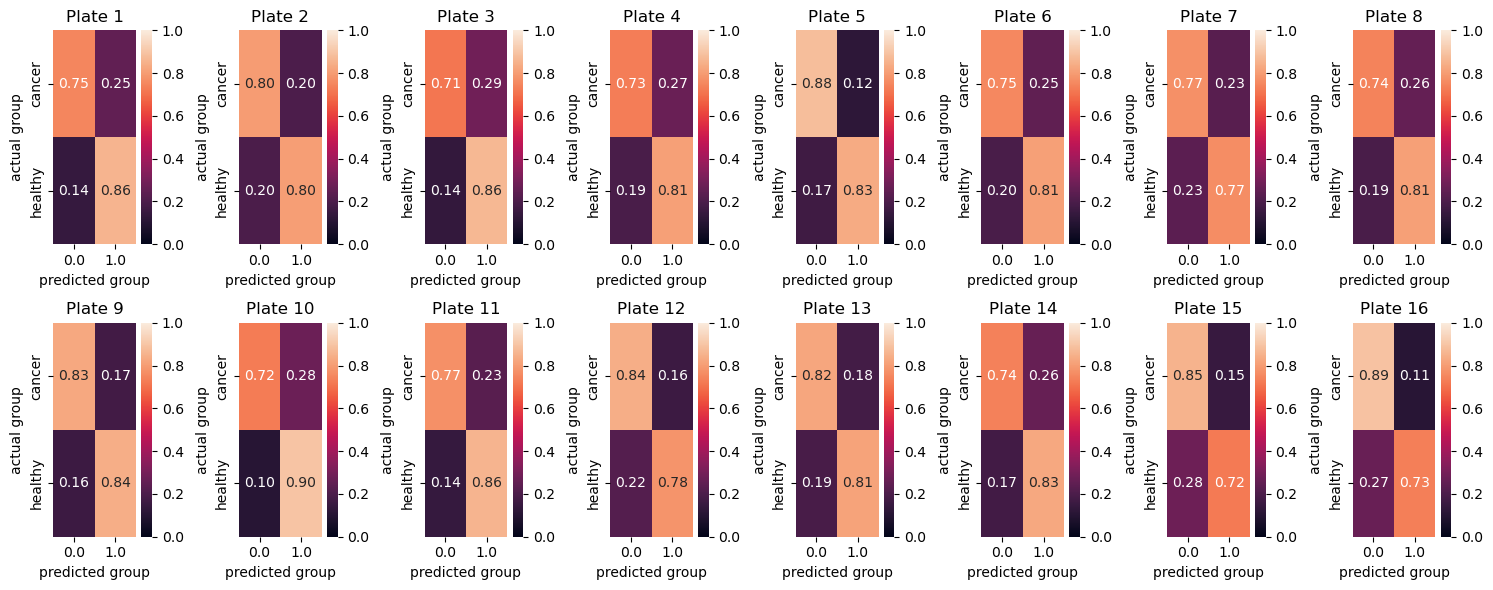

In [34]:
fig, axs = plt.subplots(2, 8, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = bag_df.reset_index()[bag_df.reset_index()['plate'] == plate].groupby(
    #     ['group', 'pred'])['i'].count().reset_index().pivot(index='group', columns='pred', values='i')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

# pat_df['healthy'] = pat_df['healthy'].replace({True : 'H', False : 'C'})
# fig, axs = plt.subplots(2, 7, figsize=(10, 4), sharex=True, sharey=True)
# for ax, plate in zip(axs.flatten(), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]):
#     mat = pat_df[pat_df['plate'] == str(plate)].groupby('healthy')[['pred C %', 'pred H %']].mean(
#     ).rename(columns={'pred C %' : 'C', 'pred H %' : 'H'}).loc[['H', 'C'], ['H', 'C']]
#     sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
#     ax.set_ylabel('')
#     ax.set_xlabel('')
#     ax.set_title(f'Plate {plate}')
# fig.tight_layout()

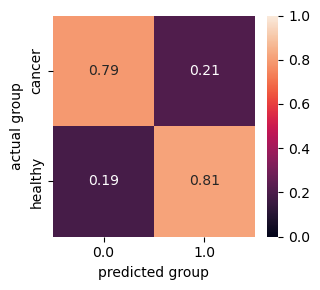

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

### Leave out one plate

iter: 99999; train loss: 0.32990813; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:25<00:00, 487.02it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_1_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.47806090; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:32<00:00, 470.29it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_2_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.32296303; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:16<00:00, 509.02it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_3_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.49837121; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:19<00:00, 501.95it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_4_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.33362666; train error: 0.14000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:50<00:00, 434.15it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_5_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.47868523; train error: 0.25999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:51<00:00, 343.45it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_6_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.49582663; train error: 0.25999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:58<00:00, 335.43it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_7_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.62456298; train error: 0.31999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:01<00:00, 331.44it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_8_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.42253596; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:49<00:00, 345.94it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_9_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.43123654; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:41<00:00, 355.17it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_10_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.44424957; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:14<00:00, 317.68it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_11_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.51562983; train error: 0.25999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:02<00:00, 330.27it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_12_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.58864903; train error: 0.28000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:14<00:00, 318.34it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_13_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.49781477; train error: 0.30000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:09<00:00, 322.78it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_14_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.46193108; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:53<00:00, 341.06it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_15_by_cell_pretrained_resnet_model.pt


iter: 99999; train loss: 0.37036759; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:54<00:00, 339.54it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_16_by_cell_pretrained_resnet_model.pt


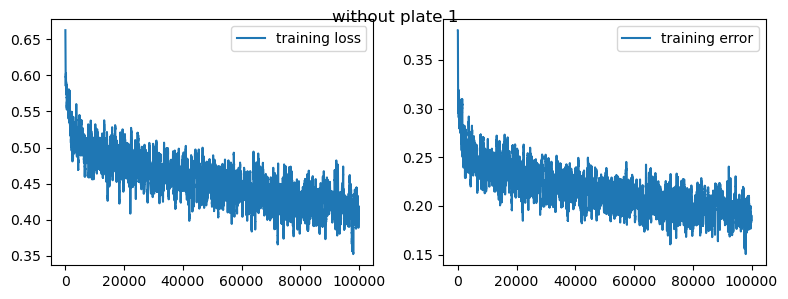

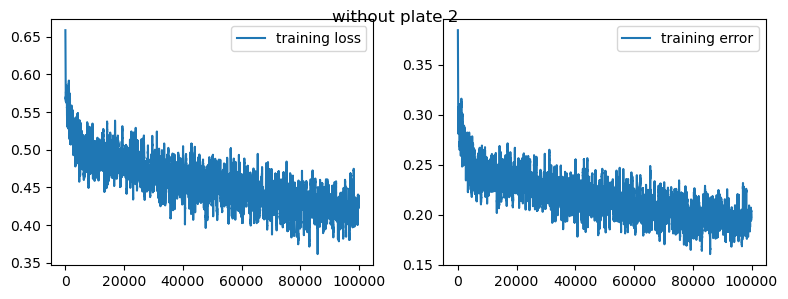

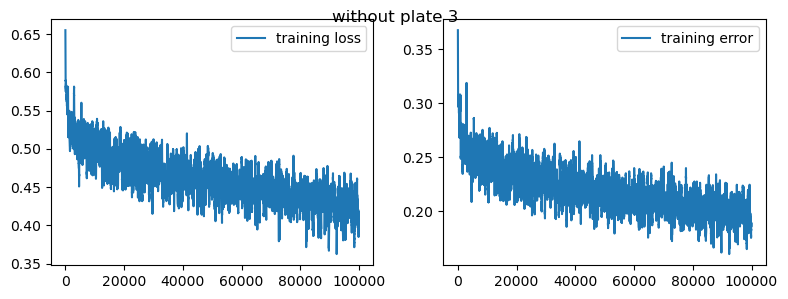

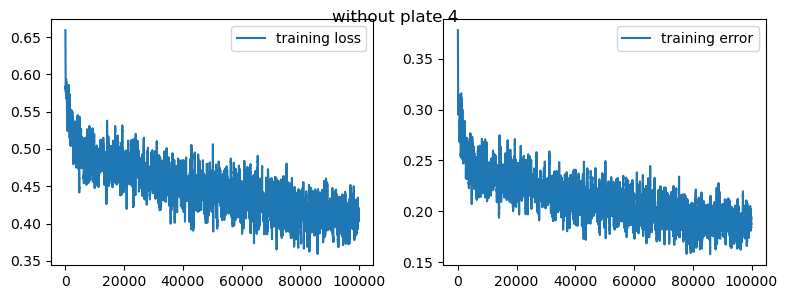

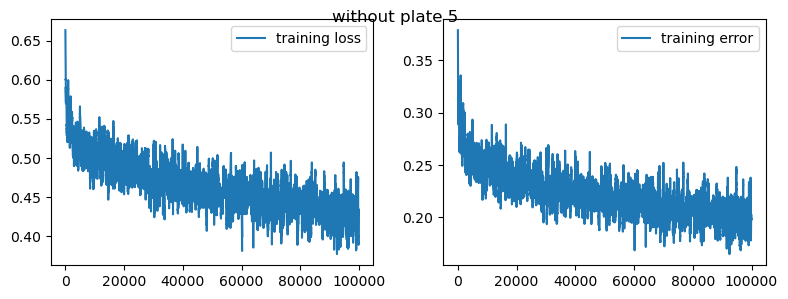

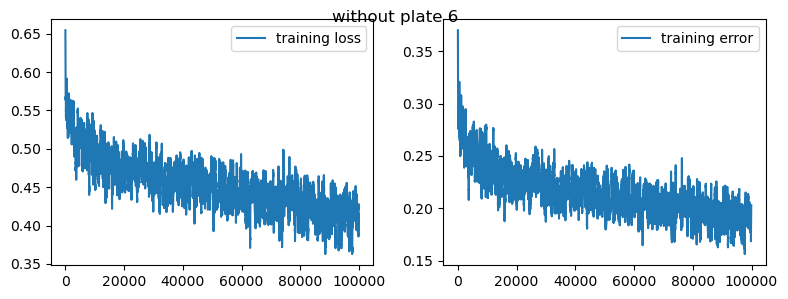

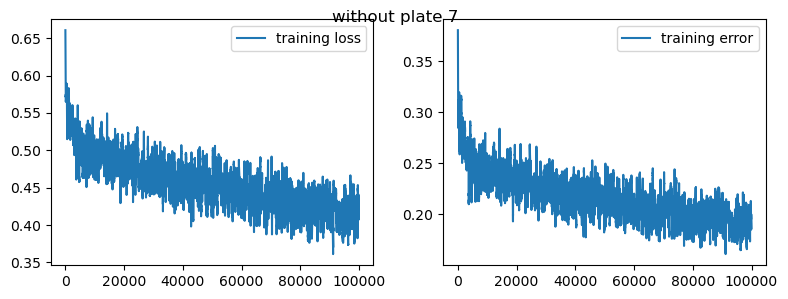

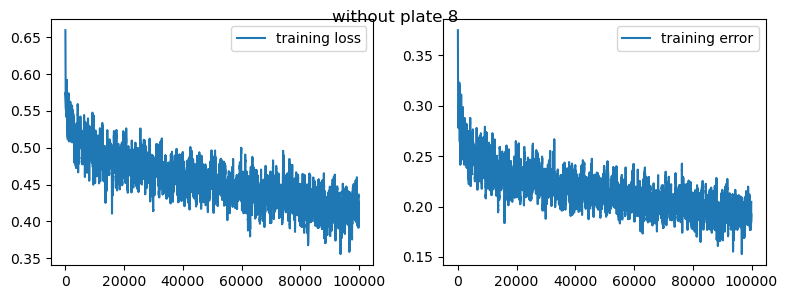

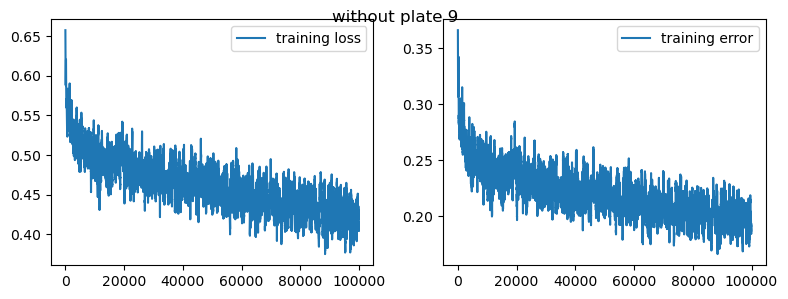

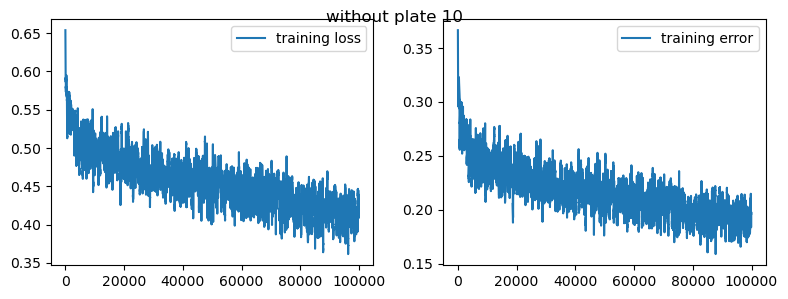

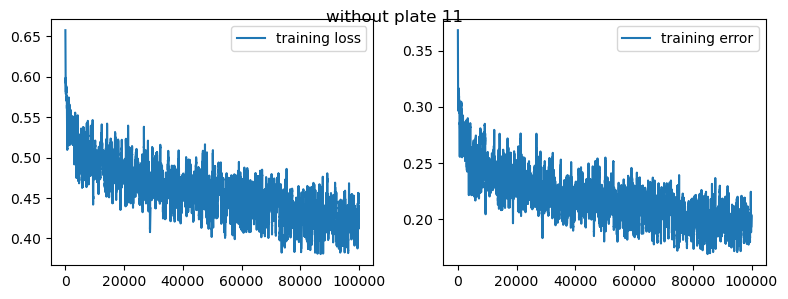

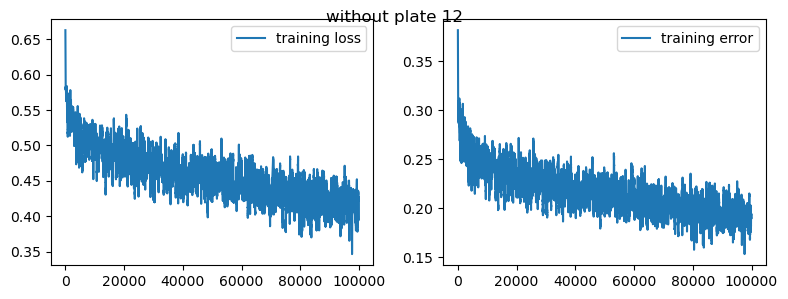

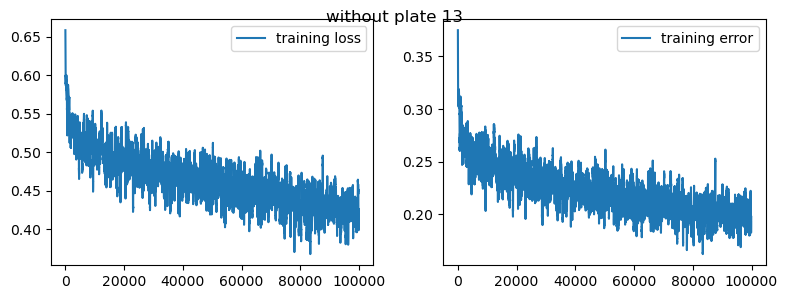

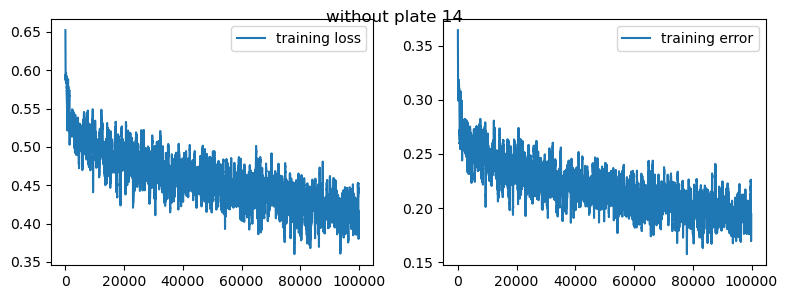

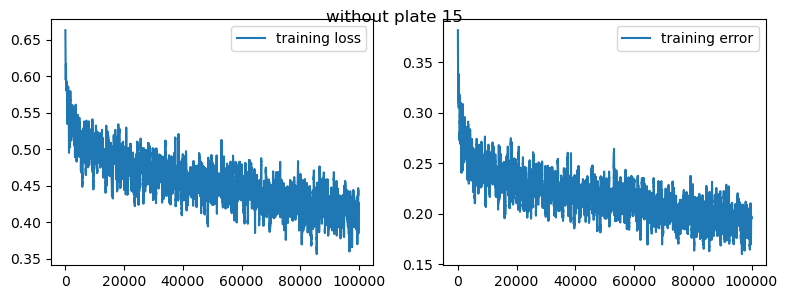

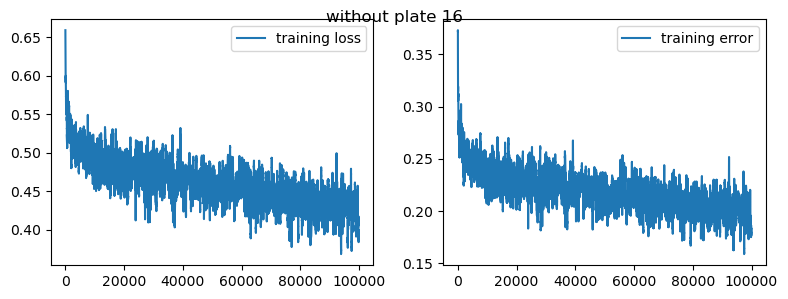

In [36]:
for plate in use_plates:
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_pretrained_resnet'
    train_loader = healthy_vs_cancer_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = FeatClassifier()
    df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                     save_model=True, seed=12341)

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

# file names are wrong in output due to typo (should be 1_16 not 1_17 for plates used)

In [37]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_pretrained_resnet', 
                        test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.58it/s]


,lab,pred,i,pat,group,plate
0,1,1.0,0,H01,healthy,1
1,1,1.0,0,H01,healthy,1
2,1,1.0,0,H01,healthy,1
3,1,0.0,0,H01,healthy,1
4,1,1.0,0,H01,healthy,1
...,...,...,...,...,...,...
20195,0,0.0,11,P74,cancer,16
20196,0,0.0,11,P74,cancer,16
20197,0,0.0,11,P74,cancer,16
20198,0,0.0,11,P74,cancer,16


In [38]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
# pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C', 'G'])
# pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C', 'G'])
pat_df

,plate,pat,group,pred,counts
0,1,H01,healthy,1.0,57
1,1,H01,healthy,0.0,43
2,1,H02,healthy,1.0,83
3,1,H02,healthy,0.0,17
4,1,H03,healthy,1.0,73
...,...,...,...,...,...
392,16,P45,cancer,0.0,100
393,16,P61,cancer,0.0,99
394,16,P61,cancer,1.0,1
395,16,P74,cancer,0.0,98


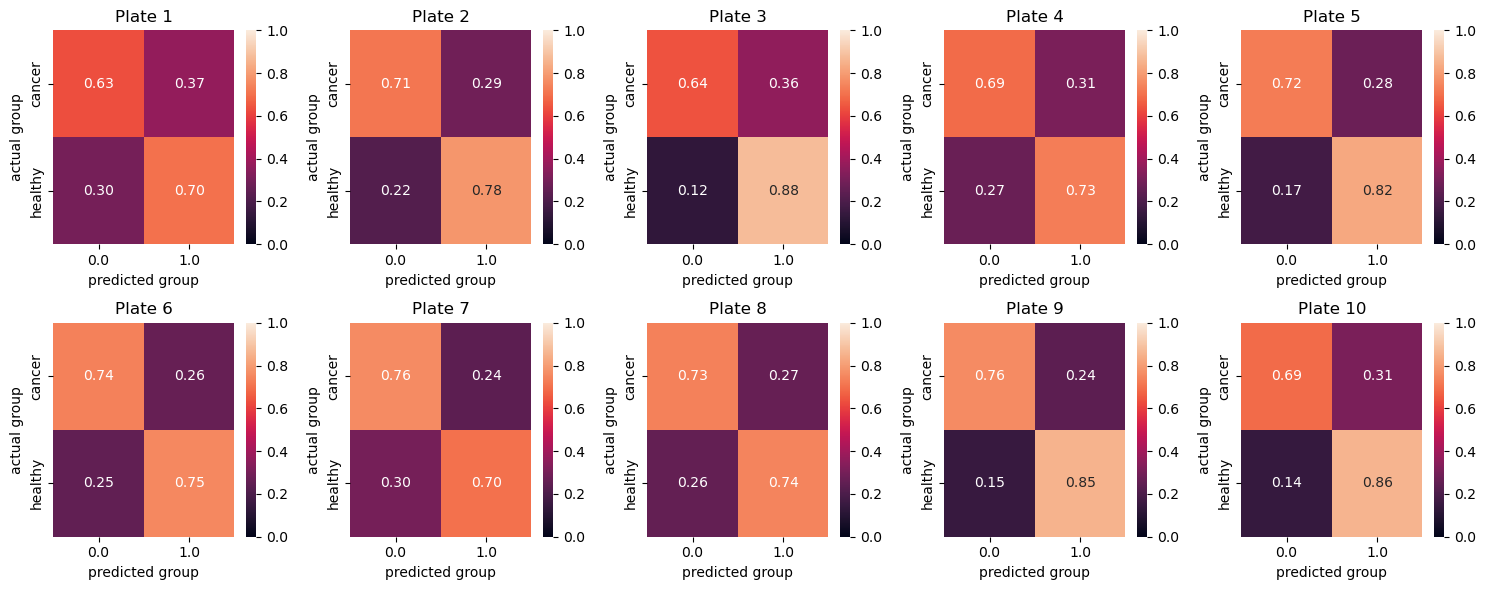

In [39]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = bag_df.reset_index()[bag_df.reset_index()['plate'] == plate].groupby(
    #     ['group', 'pred'])['i'].count().reset_index().pivot(index='group', columns='pred', values='i')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

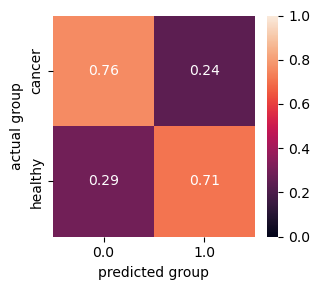

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

In [41]:
res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()

,plate,pat,group,pred
0,1,H01,healthy,0.57
1,1,H02,healthy,0.83
2,1,H03,healthy,0.73
3,1,H04,healthy,0.70
4,1,H05,healthy,0.68
...,...,...,...,...
197,16,P139,cancer,0.05
198,16,P151,cancer,0.01
199,16,P45,cancer,0.00
200,16,P61,cancer,0.01


In [42]:
pat_df = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()
plate_df = pat_df.groupby(['plate', 'group'])['pred'].mean().reset_index()
plate_df.loc[plate_df['group'] != 'healthy', 'group'] = 'C'
plate_df.loc[plate_df['group'] == 'healthy', 'group'] = 'H'
plate_df['group'] = pd.Categorical(values=plate_df['group'], categories=['H', 'C'])
plate_df['H'] = plate_df['pred']
plate_df['C'] = 1 - plate_df['H']

# pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'C'
# pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'H'
# pat_df['group'] = pat_df['group'].replace({'healthy' : 'H', 'cancer' : 'C'})
# pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['H', 'C'])
# pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['H', 'C'])
# pat_df.set_index(['plate', 'pat', 'group'])

plate_df

,plate,group,pred,H,C
0,1,C,0.368571,0.368571,0.631429
1,1,H,0.702000,0.702000,0.298000
2,2,C,0.287778,0.287778,0.712222
3,2,H,0.782500,0.782500,0.217500
4,3,C,0.362500,0.362500,0.637500
5,3,H,0.875000,0.875000,0.125000
6,4,C,0.310000,0.310000,0.690000
7,4,H,0.730000,0.730000,0.270000
8,5,C,0.276250,0.276250,0.723750
9,5,H,0.825000,0.825000,0.175000


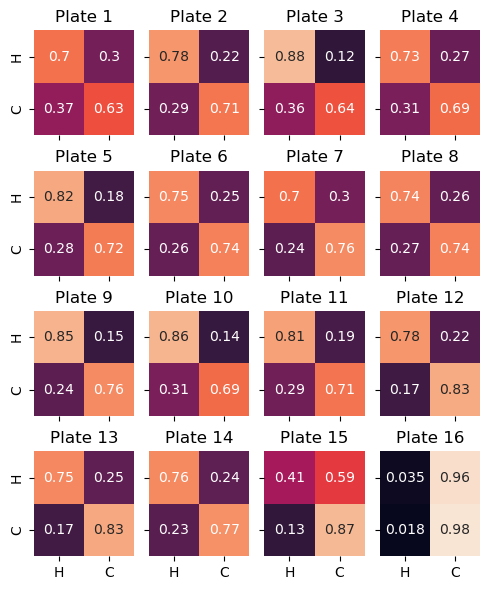

In [43]:
fig, axs = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = pat_df[pat_df['plate'] == plate].groupby(
    #     ['group', 'pred'])['pat'].count().reset_index().pivot(index='group', columns='pred', values='pat')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = plate_df[plate_df['plate'] == plate].set_index('group').loc[['H', 'C'], ['H', 'C']]
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()